# Sliding pendulum system, with control

<img align="right" width="150" src="pendulum-sliding.png">

Consider the system composed of a simple pendulum of length $l$ and mass $m$ concentrated at its bob. The pivot of the pendulum is attached to a chariot of mass $m_o$ concentrated at its centre, sliding along a horizontal rail and submitted to a uniform lateral control force field $\zeta$, possibly depending on time. The system is submitted to a uniform, constant gravitational acceleration field $g$ and moves without friction.

The generalised coordinate of the system is the position $x$ of the pivot on the rail and angle $\theta$ of the pendulum with the downward vertical direction. The standard (Cartesian) coordinates of the bob are given by
$$
x_b = x+l\sin\theta
\hspace{2cm}
y_b = -l\cos\theta
$$

The active forces are weight on the bob ($V_{(b)}=mgy$) and control on the pivot ($V_{(p)}=-\zeta x$). Hence the Lagrangian
$$
\begin{align*}
\mathcal{L} & = & \frac{1}{2}(m_o\dot{x}^2+m(\dot{x}^2+l^2\dot{\theta}^2+2l\dot{x}\dot{\theta}\cos\theta))+\zeta x+mgl\cos\theta\\
& = & \frac{1}{2}(m_o+m)\dot{x}^2+\frac{1}{2}m l^2\dot{\theta}^2+ml\dot{x}\dot{\theta}\cos\theta+\zeta x+mgl\cos\theta
\end{align*}
$$

The equations of the dynamics are given by:
$$
\begin{array}{rrcl}
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{x}} = \frac{\partial\mathcal{L}}{\partial x}\right]
\hspace{1cm} &
(m_o+m)\ddot{x}+ml\ddot{\theta}\cos\theta & = & \zeta+ml\dot{\theta}^2\sin\theta
\\
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{\theta}} = \frac{\partial\mathcal{L}}{\partial\theta}\right]
\hspace{1cm} &
\ddot{x}\cos\theta+l\ddot{\theta} & = & -g\sin\theta
\end{array}
$$
which can be rewritten as
$$
\left\{
\begin{array}{rcl}
a\ddot{x}+l\ddot{\theta}\cos\theta & = & u
\\
\ddot{x}\cos\theta+l\ddot{\theta} & = & v
\end{array}
\right.
\hspace{1cm}\textrm{where}\hspace{1cm}
\left|
\begin{array}{l}
a \triangleq 1+\frac{m_o}{m}
\\
u \triangleq \frac{\zeta}{m}+l\dot{\theta}^2\sin\theta
\hspace{1cm}
v \triangleq -g\sin\theta
\end{array}
\right.
$$

The solution in $\ddot{x},\ddot{\theta}$ is therefore
$$
\left\{
\begin{array}{rcl}
\ddot{x} & = &
\frac{u-v\cos\theta}{a-\cos^2\theta}
\\
\ddot{\theta} & = &
\frac{av-u\cos\theta}{l(a-\cos^2\theta)}
\end{array}
\right.
$$

In [1]:
import logging; logging.basicConfig(level=logging.WARNING); logging.captureWarnings(True)
from numpy import sin,cos,pi,square,sqrt,clip,array,radians,degrees
from ipyshow.odesimu import ODESystem
from ipyshow.odesimu.util import PIDControlledMixin

## ControlledPendulum class

In [2]:
#----------------------------------------------------------------------------------------------------
class ControlledPendulum (ODESystem):
#----------------------------------------------------------------------------------------------------

  def __init__(self,control,Mo,M,L,G):
    r"""
Args:
  Mo,M (float): mass of the chariot and the bob [kg]
  L (float): length of pendulum [m]
  G (float): intensity of the gravity [m.sec^-2]
  control (Callable[[float],float]): (lateral) control force field (instance of Controller class)
    """
    self.Mo, self.M, self.L, self.G = Mo, M, L, G
    self.control = control
    def fun(t,state,a=1+Mo/M):
      x,θ,xʹ,θʹ = state
      sinθ, cosθ = sin(θ), cos(θ)
      u = control(t)[0]/M+L*square(θʹ)*sinθ
      v = -G*sinθ
      D = a-square(cosθ)
      xʺ = (u-v*cosθ)/D
      θʺ = (a*v-u*cosθ)/(L*D)
      return array((xʹ,θʹ,xʺ,θʺ))
    self.fun = fun
    def cartesian(state,a=1+Mo/M):
      x,θ,xʹ,θʹ = state
      return array((x,x+L*sin(θ),-L*cos(θ)))
    self.cartesian = cartesian
    super().__init__()

  def displayer(self,trajectory,ax,refsize=80):
    r"""
Args:
  refsize (int): reference dimension for the blobs [pt^2]
    """
    Lx,Ly = 6*self.L,1.25*self.L
    ax.set(xlim=(-Lx,Lx),ylim=(-Ly,Ly))
    ax.set_title(r'cahotic',fontsize='x-small')
    ax.axhline(0,c='k')
    mo,m = self.Mo,self.M
    r = clip(sqrt(mo/m),1./refsize,refsize)
    sz = (refsize*r,refsize/r)
    a_pole, = ax.plot((),(),'k')
    a_masses = ax.scatter((0,0),(0,0),s=sz,marker='o',c=('b','r'))
    a_tail, = ax.plot((),(),'y')
    def disp(t,Lx2=2*Lx):
      x,xb,yb = self.cartesian(trajectory.state(t))
      a_pole.set_data((x,xb),(0,yb))
      a_masses.set_offsets(((x,0),(xb,yb),))
      a_tail.set_data(*self.cartesian(trajectory.cached(t))[1:])
      xr = ((x-Lx)//Lx2)*Lx2+Lx2
      ax.set(xlim=(xr-Lx,xr+Lx))
    return disp

  @staticmethod
  def makestate(x=0.,θ=0.,xʹ=0.,θʹ=0.):
    r"""
Args:
  x (float): position of the pivot [m]
  xʹ (float): speed of the pivot [m.sec^-1]
  θ (float): angle of the pendulum with downward vertical [deg]
  θʹ (float): angular speed of pendulum [deg.sec^-1]
    """
    return array((x,radians(θ),xʹ,radians(θʹ)))

  trajectory_defaults = {'period':10.,'cache_spec':(140,.05),'max_step':.05}

class PIDControlledPendulum (PIDControlledMixin,ControlledPendulum):
  trajectory_defaults = ControlledPendulum.trajectory_defaults|{'period':.1,'method':'DOP853'}
  @staticmethod
  def pos(x): return x[0],0
  @staticmethod
  def gap(o,state): return o-state[0]

IPYControlledAnimation(children=(VBox(children=(HBox(children=(SimpleButton(icon='close', layout=Layout(paddin…

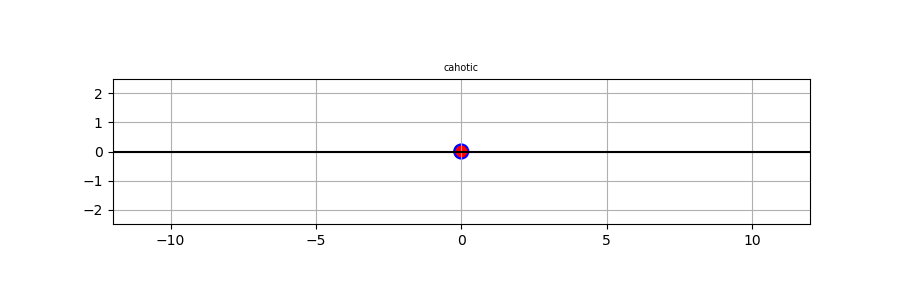

In [3]:
%matplotlib widget
#%matplotlib qt6

from ipyshow.odesimu.util import buffered
from functools import partial
class Target:
  period = 4
  @staticmethod
  def sinf(t,R=1.,D=0.,omega=2*pi/period):
    p = omega*t
    return R*sin(p)+D*t
  @staticmethod
  def sinsinf(t,R=1.,k=3.,D=0.,omega=2*pi/period):
    p = omega*t
    return R*sin(p)*sin(p/k)+D*t
  @staticmethod
  def fixed(t): return 0.,
  @staticmethod
  def buffered(f,_B=buffered(T=period,N=int(100*period)),*a,**ka): return _B(partial(f,*a,**ka))
  control = dict(
    N=2,
    gP=30.,
    #gP=.5,
    gI=10.,
    gD=20.,
    #gD=7.,
    #blur=.05,
  )

direct_control = (lambda t,A=5.,ω=.5,s=array((1.,0.)): A*(s if ω*t%2<.5 else -s))

#target = Target.buffered(Target.sinf,R=4.)
#target = Target.buffered(Target.sinsinf,R=4.,k=5.5)
target = Target.buffered(Target.sinsinf,R=4.,D=.5)
#target = Target.fixed

ini = dict(θ=179.)
#ini = dict(θ=-90.,θʹ=0.)
#ini = dict(θ=90.,θʹ=181)
#ini = dict(θ=179.)
#ini = dict(θ=90.,θʹ=degrees(sqrt(9.81))) # should be aperiodic, but appears periodic due to numerical errors

syst = PIDControlledPendulum(Target.control,target,Mo=2,M=1,L=2,G=9.81)
#syst = ControlledPendulum(direct_control,Mo=2,M=1,L=2,G=9.81)

R = syst.simulation(init_y=ini)
R.play(frame_per_stu=25,track_spec=60.,fig_kw={'figsize':(9,3)})